In [23]:
# Add parent directory to the path so we can import from there
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import copy

# Import hex maze functions to calculate a hex's distance from a reweard port
from hex_maze.hex_maze_utils import get_hexes_from_port, plot_hex_maze

### Define all of our functions here for now

Functions for loading things

In [2]:
def reduce_df_mem_usage(df, print_mem_usage=True):
    ''' 
    Given a DataFrame, return an optimized DataFrame that uses less memory. 
    
    Args:
    df (DataFrame): The DataFrame to optimize
    print_mem_usage (bool): Optional. Print the memory usage of the
    DataFrame before and after optimization. Defaults to True

    Returns:
    DataFrame: memory-optimized version of the original DataFrame
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    if (print_mem_usage):
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    if (print_mem_usage):
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))  
    return df


def clean_session_df(df, print_info=True):
    '''
    Clean the DataFrame for a session. Removes extra samples after the last
    valid trial (trial with a port entry) of the session. Also ensures that
    trial changes are aligned with block changes, removing misaligned "trials"
    of <10 samples directly before a block change. These samples will be reassigned
    to the previous trial.

    Args:
    df (DataFrame): A dataframe for a single session
    print_info (bool): Optional. Prints info about the cleaning being done.
    Defaults to True

    Returns:
    DataFrame: a cleaned version of the dataframe where each trial has exactly
    one port entry
    '''
    # Step 1: remove the extra samples after the last valid trial of the session.
    # The last valid trial is the last trial with a port entry.

    # Find the index of the last port entry in this session
    last_port_entry_idx = df[df['port'] != -100].index[-1]
    # Find which trial this occurs in
    last_valid_trial = df.loc[last_port_entry_idx, 'tri']
    # Find the end index of this trial
    df_after_last_entry = df.loc[last_port_entry_idx:]
    last_valid_trial_end = df_after_last_entry.index[df_after_last_entry['tri'] != last_valid_trial][0]

    if print_info:
        print(f"The last port entry in this session occured at index {last_port_entry_idx} in trial {int(last_valid_trial)}.")
        print(f"This trial ended at index {last_valid_trial_end}.")
        print(f"The dataframe ends at index {len(df)}. Removing the last {len(df)-last_valid_trial_end} samples ({(len(df)-last_valid_trial_end)/250} seconds)\n")

    # Remove the extra samples after the last valid trial
    clean_df = df.loc[:last_valid_trial_end - 1]

    # Step 2: Adjust the last residual trial in each block to ensure all trials 
    # have a port entry 

    # Find where the blocks change
    block_change_indices = clean_df.index[clean_df['block'] != clean_df['block'].shift()][1:].tolist()
    if print_info:
        print(f"The blocks change at indices: {block_change_indices}")
    trial_change_indices = clean_df.index[clean_df['tri'] != clean_df['tri'].shift()][1:].tolist()

    for block_num, block_change in enumerate(block_change_indices, start=1):
        # Find the index of the last trial change before the block change
        tri_change_before_block = max((idx for idx in trial_change_indices if idx < block_change), default=None)
        if print_info:
            print(f"For the block ending at index {block_change}, the last trial change in this block is at index {tri_change_before_block}")
    
        # Find the number of this trial
        trial_num = clean_df.loc[tri_change_before_block, 'tri']
        # Find the indices of this trial
        last_trial_indices = clean_df[(clean_df['block'] == block_num) & 
                                      (clean_df['tri'] == trial_num)].index
        if print_info:
            print(f"Trial {trial_num} at the end of block {block_num} spans {len(last_trial_indices)} indices ({len(last_trial_indices)/250} seconds):")
            print(last_trial_indices)
            print(f"These indices are being reassigned to the end of trial {trial_num-1}\n")

        # Reassign the last few indices to the previous trial
        if (len(last_trial_indices) <=250):
            clean_df.loc[last_trial_indices, 'tri'] = trial_num-1
        else:
            # Non-optional warn just in case
            print("Reassigning over 1 second of data - double check this is not a legitimate trial!! \n")
    
    return clean_df


def add_total_trials_to_df(df):
    '''
    Add a total_trials column to the DataFrame enumerating
    each time the 'tri' column changes. This is useful to 
    track trials for DataFrames that combine multiple sessions. 
    
    This should be run on DataFrames that have been cleaned with
    clean_session_dfs to avoud counting the "trials" of <10 samples
    that occur directly before a block changes 

    Args:
    df (DataFrame): Combined DataFrame for multiple rats/sessions

    Returns:
    DataFrame: The DataFrame with a total_trials column added
    '''
    # Find each time a trial changes
    tri_array = df['tri'].to_numpy()
    # Find where the value changes
    trial_changes = np.where(tri_array[:-1] != tri_array[1:])[0] + 1
    # Convert the result to a list and slice as needed
    trial_ends = trial_changes.tolist()
    # Make sure to include the end of the dataframe as the last trial end
    trial_ends.append(df.index[-1])
    print(f"There are {len(trial_ends)} trials in this dataframe")
    # Enumerate each trial at the trial end index in a new column 'total_trials'
    df.loc[trial_ends, 'total_trials'] = range(1, len(trial_ends) + 1)
    # Backfill each trial number from the trial end point
    df['total_trials'] = df['total_trials'].astype(float).bfill()
    return df


def load_session_dfs(session_dict, directory='/Volumes/Tim/Ephys'):
    '''
    Load all DataFrames for the specified sessions.
    Ensure position data has been interpolated and hexlabels have
    been filled between missing camera frames.
    Adds a total_trials column enumerating trials across all sessions.

    Args:
    session_dict (dict): Dictionary specifying the sessions to load, 
    where the keys are rats and the values are dates
    directory (string): The base directory prefix to load from. 
    The assumed directory structure is {directory}/{rat}/{date}/etc,
    where the rats and dates are specified by session_dict

    Returns:
    Dataframe: A combined DataFrame for all specified rats and dates.
    '''
    all_dataframes = []
    session = 1
    for rat in session_dict:
        for date in session_dict[rat]:
            # Load dataframe and add column identifying this session
            session_df = attempt_df_load(rat, date, directory)
            session_df["session"] = session
            # Ensure that position data has been interpolated
            session_df["x"] = session_df["x"].interpolate()
            session_df["y"] = session_df["y"].interpolate()
            # Ensure hexlabels have been filled between missing camera frames
            # (replace -1 with NaN so we can use ffill to forward fill the hex labels)
            session_df["hexlabels"] = session_df["hexlabels"].replace(-1, np.nan)
            session_df["hexlabels"] = session_df["hexlabels"].astype(float).ffill()
            # Make sure all trials are valid and aligned
            cleaned_session_df = clean_session_df(session_df, True)
            # Add this session to our list of dataframes
            all_dataframes.append(cleaned_session_df)
            session += 1
    # Combine all session dataframes into a single dataframe
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    # Add a total_trials column enumerating trials across all sessions
    print("Done loading, adding a 'total_trials' column...")
    combined_df = add_total_trials_to_df(combined_df)
    return combined_df


def attempt_df_load(rat, date, directory='/Volumes/Tim/Ephys'):
    '''
    Attempt to load a DataFrame for the given rat and date.
    The assumed directory structure is {directory}/{rat}/{date}/etc
    Complain if the load fails. 

    Args:
    rat (string): The ID of the rat
    date (string): The date to load, in MMDDYYYY format
    directory (string): The base directory to load from

    Returns:
    new_df (DataFrame): The loaded Dataframe, or None if the load failed
    '''
    try:
        df_path = f"{directory}/{rat}/{date}/phot_decode_df_withHexStates.csv"
        new_df = reduce_df_mem_usage(pd.read_csv(df_path))
        return new_df
    except:
        print(f"Could not load df for {rat}; {date}")
        print(f"Attempted load path was: {df_path}")


def attempt_load_barriers(rat, date, directory='/Volumes/Tim/Photometry'):
    '''
    Attempt to load a list of barriers for the given rat and date.
    The assumed directory structure is {directory}/{rat}/{date}/etc
    Complain if the load fails. 

    Args: 
    rat (string): The ID of the rat
    date (string): The date to load, in MMDDYYYY format
    directory (string): The base directory to load from

    Returns:
    barrier_sequence (list of sets): List of barrier sets used in this session,
    or None if the load failed
    '''
    barrier_sequence = []
    try:
        barriers_path = f"{directory}/{rat}/{date}/barriers.txt"
        # Read from the text file and append each set to the list
        with open(barriers_path, 'r') as txtfile:
            for line in txtfile:
                # Ignore any empty lines or lines starting with '#'
                if line.strip().startswith('#') or not line.strip():
                    continue
                # Strip any leading/trailing whitespace and split by commas
                barriers_string = line.strip().split(',')
                # Convert each number to an integer and create a set
                barrier_set = set(map(int, barriers_string))
                barrier_sequence.append(barrier_set)
            return barrier_sequence
    except:
        print(f"Could not load barriers for {rat}; {date}")
        print(f"Attempted load path was: {barriers_path}")
        return []


def nested_dict_to_df(nested_dict, metadata=True):
    '''
    Make our nested dictionary nexted_dict[session][block][trial] into a dataframe.
    Option to include or exclude session and block-level metadata.

    Args:
    nested_dict (dict): Nested dictionary of trial-level data in the format
    nested_dict[session][block][trial], with session and block-level metadata 
    nested_dict[session]['metadata'] and nested_dict[sesison][block]['metadata']
    metadata (bool): If we should include metadata info as columns in our new dataframe.
    Defaults to True

    Returns:
    DataFrame: the dictionary flattened into a DataFrame    
    '''

    # Set up list to flatten the nested dict
    flattened_data = []

    # Create copy of the dict so we can pop
    copied_dict = copy.deepcopy(nested_dict)

    # Iterate through sessions, blocks, and trials
    for session_key, session_data in copied_dict.items():
        session_metadata = session_data.pop('metadata', {})
        for block_key, block_data in session_data.items():
            block_metadata = block_data.pop('metadata', {})
            for trial_key, trial_data in block_data.items():
                # Add info for each trial
                row = {
                    'session': int(session_key),
                    'block': int(block_key),
                    'trial': int(trial_key),
                    **trial_data
                }
                # Add session and block-level metadata
                if metadata:
                    row.update(session_metadata)
                    row.update(block_metadata)
                flattened_data.append(row)
    return(pd.DataFrame(flattened_data))

In [3]:
# These are the sessions we want to use
sesh_dict = {"IM-1478":["07192022", "07202022"]}
ephys_directory = '/Volumes/Tim/Ephys'

# Load DataFrames for these sessions into a combined df
df = load_session_dfs(sesh_dict, directory=ephys_directory)

Memory usage of dataframe is 534.37 MB
Memory usage after optimization is: 125.24 MB
Decreased by 76.6%
The last port entry in this session occured at index 1729655 in trial 57.
This trial ended at index 1729767.
The dataframe ends at index 1751025. Removing the last 21258 samples (85.032 seconds)

The blocks change at indices: [450737, 1078884]
For the block ending at index 450737, the last trial change in this block is at index 450731
Trial 65 at the end of block 1 spans 6 indices (0.024 seconds):
Index([450731, 450732, 450733, 450734, 450735, 450736], dtype='int64')
These indices are being reassigned to the end of trial 64

For the block ending at index 1078884, the last trial change in this block is at index 1078876
Trial 62 at the end of block 2 spans 8 indices (0.032 seconds):
Index([1078876, 1078877, 1078878, 1078879, 1078880, 1078881, 1078882, 1078883], dtype='int64')
These indices are being reassigned to the end of trial 61

Memory usage of dataframe is 522.47 MB
Memory usage 

In [4]:
# Take a look at our loaded dataframe
display(df)
print(f"Our dataframe has these columns:\n {df.columns}")

# If we have NaN in hexlabels, replace with -1 to avoid errors
nans_in_hexlabels = df['hexlabels'].isna().sum()
print(f"There are {nans_in_hexlabels} NaNs in hexlabels. Replacing them with -1 ...")
df['hexlabels'] = df['hexlabels'].fillna(-1)
print(f"There are now {(df['hexlabels'] == -1).sum()} -1s in hexlabels.")

,Unnamed: 0,index,green_z_scored,port,rwd,x,y,nom_rwd_a,nom_rwd_b,beamA,...,decodeHPD,x_pred,y_pred,mua,theta_env,theta_phase,theta_phase_bin,pred_hexlabels,pred_hexState,total_trials
0,0,81873601,1.759766,-100,0,324.50,53.65625,90.0,10.0,0.0,...,4164.0,505.75,470.2500,5.007812,2.007812,-1.514648,"(-1.692, -1.208]",-1,-1,1.0
1,1,81873602,1.776367,-100,0,324.50,53.71875,90.0,10.0,0.0,...,3188.0,499.50,464.0000,5.433594,2.007812,-1.365234,"(-1.692, -1.208]",-1,-1,1.0
2,2,81873603,1.774414,-100,0,324.50,53.81250,90.0,10.0,0.0,...,3706.0,499.50,470.2500,5.738281,2.007812,-1.161133,"(-1.208, -0.725]",-1,-1,1.0
3,3,81873604,1.750000,-100,0,324.50,53.87500,90.0,10.0,0.0,...,3878.0,499.50,464.0000,5.890625,2.007812,-0.939941,"(-1.208, -0.725]",-1,-1,1.0
4,4,81873605,1.703125,-100,0,324.50,53.93750,90.0,10.0,0.0,...,2754.0,499.50,464.0000,5.878906,2.007812,-0.713379,"(-0.725, -0.242]",-1,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3391931,1662164,95307921,-1.554688,-100,0,321.50,52.96875,90.0,10.0,0.0,...,3454.0,199.50,203.3750,10.000000,3.423828,-2.035156,"(-2.175, -1.692]",-1,-1,297.0
3391932,1662165,95307922,-1.505859,-100,0,321.50,53.03125,90.0,10.0,0.0,...,5816.0,330.75,53.1875,10.515625,3.425781,-1.843750,"(-2.175, -1.692]",1,-1,297.0
3391933,1662166,95307923,-1.427734,-100,0,321.75,53.09375,90.0,10.0,0.0,...,5732.0,337.00,53.1875,11.023438,3.427734,-1.649414,"(-1.692, -1.208]",1,-1,297.0
3391934,1662167,95307924,-1.327148,-100,0,321.75,53.15625,90.0,10.0,0.0,...,2954.0,337.00,59.4375,11.468750,3.427734,-1.453125,"(-1.692, -1.208]",1,-1,297.0


Our dataframe has these columns:
 Index(['Unnamed: 0', 'index', 'green_z_scored', 'port', 'rwd', 'x', 'y',
       'nom_rwd_a', 'nom_rwd_b', 'beamA', 'beamB', 'beamC', 'tri', 'block',
       'nom_rwd_c', 'hexlabels', 'lenAC', 'lenBC', 'lenAB', 'dtop', 'fiberloc',
       'session_type', 'session', 'rat', 'date', 'lastleave', 'nom_rwd_chosen',
       'vel', 'pairedHexStates', 'acc', 'decodeDistToRat', 'decodeHPD',
       'x_pred', 'y_pred', 'mua', 'theta_env', 'theta_phase',
       'theta_phase_bin', 'pred_hexlabels', 'pred_hexState', 'total_trials'],
      dtype='object')
There are 0 NaNs in hexlabels. Replacing them with -1 ...
There are now 0 -1s in hexlabels.


For each trial: get the rat's hex path and the DA in each hex

In [30]:
# inputs: df
# outputs: trial level dict including:
# reward port, rat's hex path, time in each hex, and mean DA in each hex

# Make sure these columns have the data types we want so we can use groupby
df['session'] = df['session'].astype('int')
df['block'] = df['block'].astype('int')
df['tri'] = df['tri'].astype('float32')

# Initialize a dict to store info by trial_dict[session][block][trial]
trial_dict = {}
for session, session_df in df.groupby('session'):
    # Get the session type, rat, and date for this session
    session_type = session_df['session_type'].iloc[0]
    rat = session_df['rat'].iloc[0]
    date = session_df['date'].iloc[0]
    # If the date doesn't have a leading 0 and needs one, add it
    date = '0' + str(date) if not str(date)[0] in ('1', '0') else str(date)
    # Add session-level metadata (date, rat, session type)
    session_metadata = {'date': date, 'rat': rat, 'session_type': session_type}
    trial_dict[session] = {'metadata': session_metadata}
    # Load the barriers for all blocks in this session
    barrier_sequence = attempt_load_barriers(rat, date)
    for block, block_df in session_df.groupby('block'):
        # Add block-level metadata (barriers, reward probabilities)
        block_metadata = {'barriers': barrier_sequence[int(block)-1], 
                          'nom_rwd_a': block_df['nom_rwd_a'].iloc[0],
                          'nom_rwd_b': block_df['nom_rwd_b'].iloc[0], 
                          'nom_rwd_c': block_df['nom_rwd_c'].iloc[0]}
        trial_dict[session][block] = {'metadata': block_metadata}

# Get a subset of the df for a specific session, block, and trial
for (session, block, trial), trial_df in df.groupby(['session', 'block', 'tri']):
    # Find each time the rat enters a new hex in this trial
    hex_change_indices = np.where(trial_df['hexlabels'] != trial_df['hexlabels'].shift())[0]

    # Use these to get the rat's hex path for this trial as a list of ints
    hex_path = trial_df['hexlabels'].iloc[hex_change_indices].astype(int).tolist()
    # Remove all instances of -1
    hex_path = [hex for hex in hex_path if hex != -1]

    # Add end index of this trial as the final hex change for calculating mean DA + time in hex
    hex_change_indices = np.append(hex_change_indices, len(trial_df))

    # Calculate mean DA for each hex
    mean_hex_da = [trial_df['green_z_scored'].iloc[hex_change_indices[i]:hex_change_indices[i + 1]].mean()
                        for i in range(len(hex_change_indices) - 1)]
    # Calculate time spent in each hex (in samples)
    time_in_hex = [hex_change_indices[i + 1] - hex_change_indices[i]
                      for i in range(len(hex_change_indices) - 1)]
    
    # Find when the rat enters a reward port in this trial
    port_entry_idx = trial_df.index[trial_df['port'] != -100]
    # Find the target reward port for this trial (change 0, 1, 2 to be 1, 2, 3)
    port = trial_df.loc[port_entry_idx, "port"].iloc[0]+1

    # Get the maze configuration for this block (it is already in our trial_dict metadata)
    # maze is the set of barriers for this maze
    maze = trial_dict[session][block]['metadata'].get('barriers')

    # We sometimes have badly assigned hexes </3 complain about it here
    barriers_in_hex_path = set(hex_path) & maze
    if barriers_in_hex_path:
        print("We have a barrier in our hex path!!!!")
        print(f"Barriers are: {maze}")
        print(f"Hex path is: {hex_path}")
        print(f"The offending hex is {barriers_in_hex_path}")
 
        # Find indices of the barriers in hex_path so we can remove them
        # and remove the corresponding entries in mean_hex_da and time_in_hex
        bad_hex_indices = [index for index, hex in enumerate(hex_path) if hex in maze]
        # Remove data for hexes assigned to barriers
        hex_path = [hex for i, hex in enumerate(hex_path) if i not in bad_hex_indices]
        mean_hex_da = [da for i, da in enumerate(mean_hex_da) if i not in bad_hex_indices]
        time_in_hex = [time for i, time in enumerate(time_in_hex) if i not in bad_hex_indices]

    # For each (valid) hex in the rat's hex path, find the distance from the port
    hexes_from_port = [get_hexes_from_port(maze, hex, port) for hex in hex_path]

    # Add the info to our dictionary
    trial_data = {'hex_path': hex_path,
                  'hexes_from_port': hexes_from_port,
                  'time_in_hex': time_in_hex,
                  'mean_hex_da':  mean_hex_da,
                  'port': port,
                  'rwd': trial_df.loc[port_entry_idx, "rwd"].iloc[0]}
    trial_dict[session][block][trial] = trial_data


We have a barrier in our hex path!!!!
Barriers are: {35, 8, 9, 42, 44, 16, 18, 23, 27}
Hex path is: [3, 48, 43, 39, 29, 24, 20, 25, 21, 17, 21, 26, 31, 37, 31, 36, 41, 46, 41, 45, 46, 45, 42, 46, 36, 31, 26, 21, 25, 20, 24, 29, 34, 29, 24, 20, 25, 21, 17, 13, 10, 5, 4, 1]
The offending hex is {42}
We have a barrier in our hex path!!!!
Barriers are: {35, 8, 9, 42, 44, 16, 18, 23, 27}
Hex path is: [3, 48, 33, 28, 34, 29, 24, 20, 25, 21, 17, 21, 26, 31, 36, 41, 46, 41, 45, 40, 45, 36, 31, 45, 41, 45, 36, 45, 31, 45, 36, 45, 40, 45, 41, 46, 42, 46, 41, 45, 40, 45, 42, 45, 41, 46, 42, 46, 41, 36, 31, 37, 32, 38, 49]
The offending hex is {42}
We have a barrier in our hex path!!!!
Barriers are: {35, 8, 9, 42, 44, 16, 18, 23, 27}
Hex path is: [3, 48, 39, 44, 39, 28, 33, 48, 3, 48, 33, 28, 34, 29, 24, 20, 25, 21, 17, 13, 10, 7, 5, 4, 1]
The offending hex is {44}
We have a barrier in our hex path!!!!
Barriers are: {35, 8, 9, 42, 44, 18, 21, 23, 27}
Hex path is: [3, 48, 43, 39, 34, 29, 35, 29, 24

In [32]:
# Example of accessing the data and metadata from the trial_dict
print("Session 1 metadata:", trial_dict[1]['metadata'])
print("Block 2 metadata in session 1:", trial_dict[1][2]['metadata'])
print("Trial 4 data in block 2 of session 1:", trial_dict[1][2][4])

Session 1 metadata: {'date': '07192022', 'rat': 'IM-1478', 'session_type': 'barrier'}
Block 2 metadata in session 1: {'barriers': {35, 8, 9, 42, 44, 18, 21, 23, 27}, 'nom_rwd_a': 90.0, 'nom_rwd_b': 10.0, 'nom_rwd_c': 50.0}
Trial 4 data in block 2 of session 1: {'hex_path': [4, 1, 4, 5, 7, 10, 13, 16, 20, 24, 19, 24, 29, 34, 28, 33, 48, 3], 'hexes_from_port': [13, 14, 13, 12, 11, 10, 9, 8, 7, 6, 7, 6, 5, 4, 3, 2, 1, 0], 'time_in_hex': [3308, 232, 32, 116, 52, 48, 85, 52, 100, 515, 33, 151, 132, 53, 48, 51, 48, 155], 'mean_hex_da': [-0.2125, -0.665, -0.2673, -0.1101, -0.4714, -0.526, -0.4558, -0.7344, -0.01804, 0.004078, -0.1206, -0.825, -0.281, -0.56, -0.5776, -0.176, 0.0717, 1.032], 'port': 3, 'rwd': 1}


In [33]:
# Go from nested dict to df once again... 
# still deciding how I want to represent things and it feels ugly but I'm fine
trial_df = nested_dict_to_df(trial_dict, metadata=True)
display(trial_df)

,session,block,trial,hex_path,hexes_from_port,time_in_hex,mean_hex_da,port,rwd,date,rat,session_type,barriers,nom_rwd_a,nom_rwd_b,nom_rwd_c
0,1,1,4,"[1, 4, 5, 7, 10, 13, 17, 21, 26, 31, 37, 32, 3...","[14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]","[1200, 48, 136, 16, 48, 85, 36, 399, 80, 268, ...","[-0.1849, -0.2343, -0.0707, -0.04993, -0.6284,...",2,0,07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0
1,1,1,5,"[49, 2, 49, 38, 32, 37, 31, 26, 21, 17, 21, 25...","[15, 16, 15, 14, 13, 12, 11, 10, 9, 10, 9, 8, ...","[1313, 147, 468, 49, 68, 67, 348, 16, 236, 165...","[-0.0229, -0.0963, -0.2634, -0.3127, -0.205, -...",3,0,07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0
2,1,1,6,"[3, 48, 43, 39, 29, 24, 20, 25, 21, 17, 21, 26...","[16, 15, 14, 13, 11, 10, 9, 8, 7, 6, 7, 8, 9, ...","[168, 67, 17, 99, 53, 147, 252, 6380, 1952, 18...","[-0.1975, -1.518, -1.147, -0.928, -1.087, -0.9...",1,1,07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0
3,1,1,7,"[1, 4, 6, 4, 5, 7, 10, 13, 21, 26, 31, 36, 30,...","[14, 13, 14, 13, 12, 11, 10, 9, 7, 6, 5, 6, 7,...","[2359, 836, 148, 116, 68, 68, 32, 84, 100, 32,...","[0.33, 0.1681, -0.554, 0.2354, 0.01383, -0.349...",2,0,07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0
4,1,1,8,"[49, 2, 49, 47, 49, 38, 32, 37, 31, 21, 25, 20...","[15, 16, 15, 16, 15, 14, 13, 12, 11, 9, 8, 7, ...","[995, 999, 369, 415, 100, 53, 280, 51, 149, 21...","[-0.3276, 0.02718, 0.6367, 0.04617, -0.3318, -...",3,1,07192022,IM-1478,barrier,"{35, 8, 9, 42, 44, 16, 18, 23, 27}",90.0,10.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2,2,46,"[4, 1, 4, 5, 7, 12, 16, 20, 24, 29, 35, 40, 45...","[19, 20, 19, 18, 17, 15, 14, 13, 12, 11, 10, 9...","[5098, 200, 68, 68, 116, 68, 64, 118, 50, 68, ...","[-0.3352, -0.721, -0.654, -0.489, 0.11646, -0....",2,0,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}",90.0,10.0,50.0
293,2,2,47,"[49, 2, 49, 38, 32, 27, 32, 38, 49, 2, 49, 38,...","[17, 18, 17, 16, 15, 16, 15, 16, 17, 18, 17, 1...","[4836, 116, 216, 68, 184, 12532, 217, 52, 780,...","[-0.2389, -0.693, -0.821, -0.722, -0.00266, 0....",3,0,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}",90.0,10.0,50.0
294,2,2,48,"[48, 3, 48, 43, 48, 3, 48, 28, 23, 19, 24, 20,...","[13, 14, 13, 14, 13, 14, 13, 11, 10, 9, 8, 7, ...","[2840, 532, 620, 200, 264, 1200, 268, 68, 48, ...","[0.268, -0.1473, -0.4358, 0.1581, -0.2803, 0.0...",1,1,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}",90.0,10.0,50.0
295,2,2,49,"[1, 4, 6, 8, 11, 8, 6, 4, 1, 4, 5, 7, 12, 16, ...","[20, 19, 20, 21, 22, 21, 20, 19, 20, 19, 18, 1...","[1370, 116, 116, 52, 6684, 164, 52, 48, 220, 4...","[-0.4084, -0.909, -0.4993, 0.2206, -0.1683, 0....",2,0,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}",90.0,10.0,50.0


Plot the rat's dopamine as a function of the number of hexes from the reward port

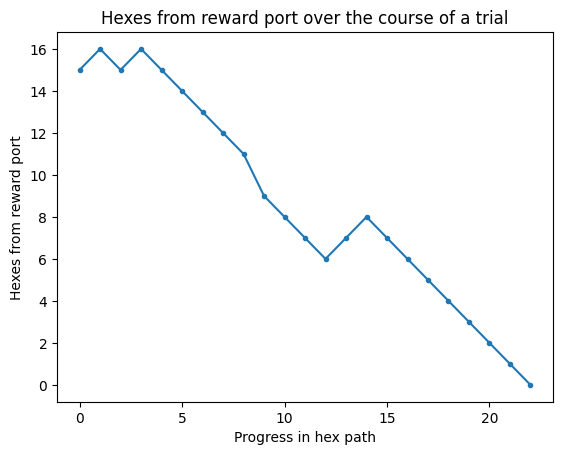

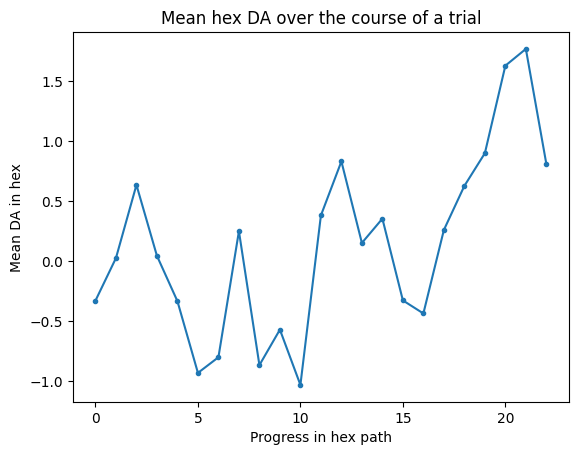

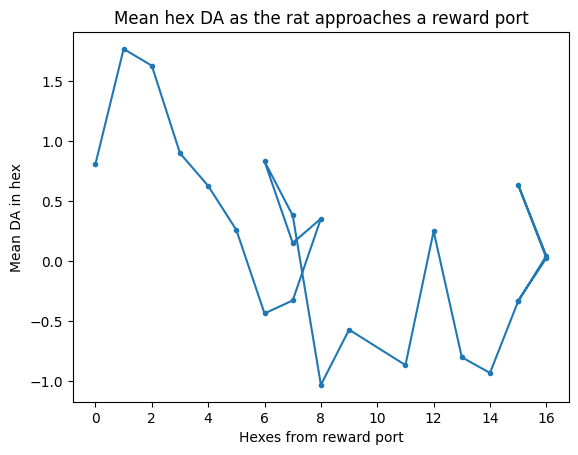

In [87]:
# First plot a single trial as a sanity check
# (Change row number to see different trials)
row = 4
hexes_from_port = trial_df.loc[row, 'hexes_from_port']
mean_hex_da = trial_df.loc[row, 'mean_hex_da']

plt.figure()
plt.plot(hexes_from_port, '.-')
plt.xlabel('Progress in hex path')
plt.ylabel('Hexes from reward port')
plt.title('Hexes from reward port over the course of a trial')
plt.show()

plt.figure()
plt.plot(mean_hex_da, '.-')
plt.xlabel('Progress in hex path')
plt.ylabel('Mean DA in hex')
plt.title('Mean hex DA over the course of a trial')
plt.show()

plt.figure()
plt.plot(hexes_from_port, mean_hex_da, '.-')
plt.xlabel('Hexes from reward port')
plt.ylabel('Mean DA in hex')
plt.title('Mean hex DA as the rat approaches a reward port')
plt.show()

In [78]:
# Now aggregate the hex DA at the distance from the port across all trials
from collections import defaultdict

hexes_from_port_lists = trial_df['hexes_from_port']
mean_hex_da_lists = trial_df['mean_hex_da']

# Initialize defaultdict to collect a list of hex DA for each hex distance from port
hex_da_by_hexes_from_port = defaultdict(list)

# Iterate over each pair of hex DA and corresponding hexes from port for each trial
for mean_hex_da, hexes_from_port in zip(mean_hex_da_lists, hexes_from_port_lists):
    for da, hex_distance in zip(mean_hex_da, hexes_from_port):
        # Append hex DA to the list corresponding to the distance from the port
        hex_da_by_hexes_from_port[hex_distance].append(da)

# Convert defaultdict to a regular dictionary
hex_da_by_hexes_from_port = dict(hex_da_by_hexes_from_port)

# Get overall mean and std of hex DA by hexes from reward port
overall_mean_hex_da_dict = {}
overall_std_hex_da_dict = {}

# Iterate over each distance from port and corresponding list of hex DA
for hex_distance, da in hex_da_by_hexes_from_port.items():
    print(f"All mean hex DA {hex_distance} hexes from port: {da}")
    # Get overall mean and std of DA at each hex distance from the reward port
    overall_mean_hex_da_dict[hex_distance] = np.mean(da)
    overall_std_hex_da_dict[hex_distance] = np.std(da)
    print(f"Overall mean: {np.mean(da):.3f}, std: {np.std(da):.3f} from {len(da)} samples")

All mean hex DA 14 hexes from port: [-0.1849, -0.3127, -1.147, 0.33, -0.554, -0.929, -0.544, 0.316, 1.506, -0.8335, -0.6006, -0.1372, -0.3225, 0.01082, -0.3586, 1.047, 0.981, -0.4536, -0.8013, -0.4373, 0.2037, 0.10565, 0.476, -0.2168, -0.297, -0.2793, 1.601, -0.4229, -0.994, 0.3484, -0.7427, -0.9404, 0.2064, -0.825, -0.1985, 0.014534, 0.2103, -0.002209, 0.4587, 0.2026, 0.349, 0.1294, -0.68, 0.3457, -0.4841, -0.2607, -0.509, -0.0887, -0.254, -0.538, -0.5625, -0.7583, -0.4841, -0.7114, 0.03552, -0.0728, -0.7705, -0.642, -0.2301, 0.1092, -0.1848, -0.54, 0.0902, -0.8145, 0.5635, -0.676, -0.4595, 0.1705, -0.2542, 0.03226, -0.651, 0.672, -0.5474, -0.1885, -0.4565, -0.665, -0.01918, -0.3914, 0.02234, -0.3955, -0.1631, -0.503, -0.7197, -0.2108, -0.3293, -0.5737, 0.2712, -0.4456, 2.834, -0.5957, -1.11, -1.272, -0.5205, 0.6553, 0.4534, -0.71, -0.1023, -0.677, 0.1373, -0.4543, 0.4275, -0.118, -0.433, -0.1779, 0.159, -0.678, -0.04443, -0.51, -0.4639, -0.3113, 0.453, -0.09454, -0.3672, 0.3525, -0.5

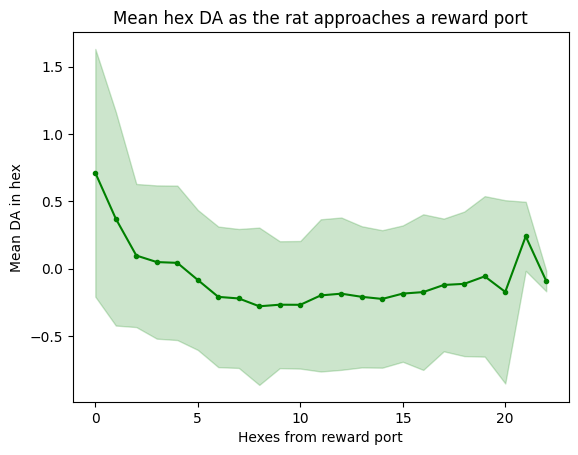

In [80]:
# Plot it!!!!!

# Sort so plotting doesn't get weird
hexes_from_port = sorted(overall_mean_hex_da_dict.keys())
overall_mean_hex_da = [overall_mean_hex_da_dict[hex_dist] for hex_dist in hexes_from_port]
overall_std_hex_da = [overall_std_hex_da_dict[hex_dist] for hex_dist in hexes_from_port]

plt.figure()
plt.plot(hexes_from_port, overall_mean_hex_da, '.-', color='g')
plt.fill_between(hexes_from_port, np.subtract(overall_mean_hex_da,overall_std_hex_da), np.add(overall_mean_hex_da,overall_std_hex_da), alpha=0.2, color='g')
plt.xlabel('Hexes from reward port')
plt.ylabel('Mean DA in hex')
plt.title('Mean hex DA as the rat approaches a reward port')
plt.show()